# Survival analysis

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkplot.py")

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import thinkplot

<IPython.core.display.Javascript object>

**Survival analysis** is a way to describe how long things last. It is
often used to study human lifetimes, but it also applies to "survival"
of mechanical and electronic components, or more generally to intervals
in time before an event.

If someone you know has been diagnosed with a life-threatening disease,
you might have seen a "5-year survival rate," which is the probability
of surviving five years after diagnosis. That estimate and related
statistics are the result of survival analysis.

## Survival curves

The fundamental concept in survival analysis is the **survival curve**,
$S(t)$, which is a function that maps from a duration, $t$, to the
probability of surviving longer than $t$. If you know the distribution
of durations, or "lifetimes", finding the survival curve is easy; it's
just the complement of the CDF: 

$$S(t) = 1 - CDF(t)$$ 

where $CDF(t)$ is the probability of a lifetime less than or equal to $t$.

For example, in the NSFG dataset, we know the duration of 11,189 complete
pregnancies. We can read this data and compute the CDF:

In [28]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [29]:
import nsfg

preg = nsfg.read_fem_preg()
preg.prglngth.count()

13593

<IPython.core.display.Javascript object>

In [30]:
complete = preg.query("outcome in [1, 3, 4]").prglngth
complete.count()

11189

<IPython.core.display.Javascript object>

In [31]:
from thinkstats import Cdf

cdf = Cdf(complete, label="cdf")

<IPython.core.display.Javascript object>

The outcome codes `1, 3, 4` indicate live birth, stillbirth, and
miscarriage. For this analysis I am excluding induced abortions, ectopic
pregnancies, and pregnancies that were in progress when the respondent
was interviewed.

The DataFrame method `query` takes a boolean expression and evaluates it
for each row, selecting the rows that yield True.

`SurvivalFunction` provides two properties: `ts`, which is the sequence
of lifetimes, and `ss`, which is the survival curve. In Python, a
"property" is a method that can be invoked as if it were a variable.

We can instantiate a `SurvivalFunction` by passing the CDF of lifetimes:

In [32]:
from thinkstats import SurvivalFunction


def make_survival_from_cdf(cdf, label=""):
    """Makes a survival function based on a CDF.

    cdf: Cdf

    returns: SurvivalFunction
    """
    ts = cdf.xs
    ss = 1 - cdf.ps
    return SurvivalFunction(ts, ss, label)

<IPython.core.display.Javascript object>

In [33]:
sf = make_survival_from_cdf(cdf, label="survival")

<IPython.core.display.Javascript object>

`SurvivalFunction` also provides `__getitem__` and `Prob`, which
evaluates the survival curve:

For example, `sf[13]` is the fraction of pregnancies that proceed past
the first trimester:

In [34]:
sf[13]

0.8602198587898829

<IPython.core.display.Javascript object>

In [35]:
cdf[13]

0.1397801412101171

<IPython.core.display.Javascript object>

About 86% of pregnancies proceed past the first trimester; about 14% do
not.

The following figure shows the CDF of pregnancy length and its
complement, the survival curve. To represent the survival curve, I
define an object that wraps a `Cdf` and adapts the interface:

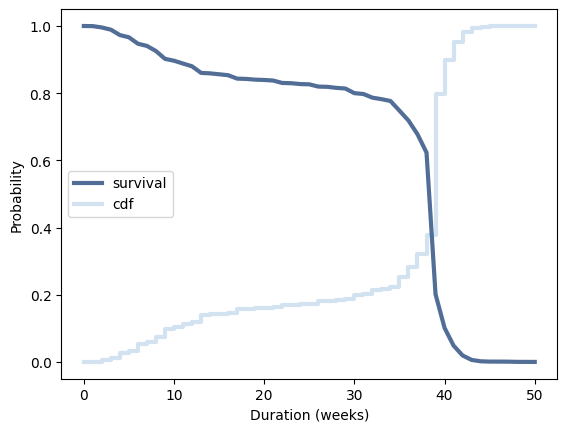

<IPython.core.display.Javascript object>

In [40]:
thinkplot.plot(sf)
thinkplot.cdf(cdf, alpha=0.2)
thinkplot.config(xlabel="Duration (weeks)", ylabel="Probability")

The curve is nearly flat
between 13 and 26 weeks, which shows that few pregnancies end in the
second trimester. And the curve is steepest around 39 weeks, which is
the most common pregnancy length.

## Hazard function

From the survival curve we can derive the **hazard function**; for
pregnancy lengths, the hazard function maps from a time, $t$, to the
fraction of pregnancies that continue until $t$ and then end at $t$. To
be more precise: 

$$\lambda(t) = \frac{S(t) - S(t+1)}{S(t)}$$ 

The
numerator is the fraction of lifetimes that end at $t$, which is also
$PMF(t)$.

`SurvivalFunction` provides `make_hazard_function`, which calculates the hazard function:

In [37]:
hf = sf.make_hazard_function(label="hazard")

<IPython.core.display.Javascript object>

The result is a `HazardFunction` object, whichwe can evaluate it like
this:

In [38]:
hf[39]

0.6767068273092369

<IPython.core.display.Javascript object>

So of all pregnancies that proceed until week 39, about 50% end in week
39.

The following figure shows the hazard function for pregnancy
lengths. For times after week 42, the hazard function is erratic because
it is based on a small number of cases. Other than that the shape of the
curve is as expected: it is highest around 39 weeks, and a little higher
in the first trimester than in the second.

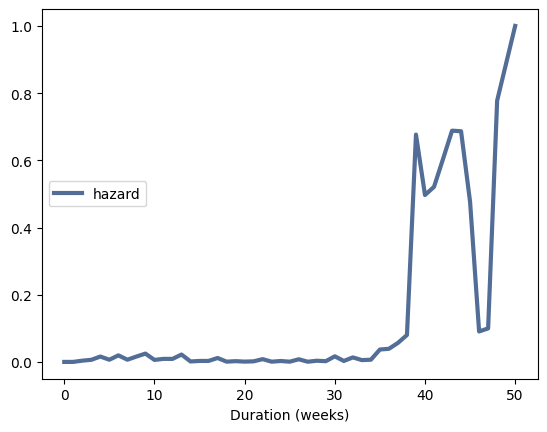

<IPython.core.display.Javascript object>

In [39]:
thinkplot.plot(hf)
thinkplot.config(xlabel="Duration (weeks)", ylabel='Hazard rate')

The hazard function is useful in its own right, but it is also an
important tool for estimating survival curves, as we'll see in the next
section.

## Inferring survival curves

If someone gives you the CDF of lifetimes, it is easy to compute the
survival and hazard functions. But in many real-world scenarios, we
can't measure the distribution of lifetimes directly. We have to infer
it.

For example, suppose you are following a group of patients to see how
long they survive after diagnosis. Not all patients are diagnosed on the
same day, so at any point in time, some patients have survived longer
than others. If some patients have died, we know their survival times.
For patients who are still alive, we don't know survival times, but we
have a lower bound.

If we wait until all patients are dead, we can compute the survival
curve, but if we are evaluating the effectiveness of a new treatment, we
can't wait that long! We need a way to estimate survival curves using
incomplete information.

As a more cheerful example, I will use NSFG data to quantify how long
respondents "survive" until they get married for the first time. The
range of respondents' ages is 14 to 44 years, so the dataset provides a
snapshot of women at different stages in their lives.

For women who have been married, the dataset includes the date of their
first marriage and their age at the time. For women who have not been
married, we know their age when interviewed, but have no way of knowing
when or if they will get married.

Since we know the age at first marriage for *some* women, it might be
tempting to exclude the rest and compute the CDF of the known data. That
is a bad idea. The result would be doubly misleading: (1) older women
would be overrepresented, because they are more likely to be married
when interviewed, and (2) married women would be overrepresented! In
fact, this analysis would lead to the conclusion that all women get
married, which is obviously incorrect.

## Kaplan-Meier estimation

In this example it is not only desirable but necessary to include
observations of unmarried women, which brings us to one of the central
algorithms in survival analysis, **Kaplan-Meier estimation**.

The general idea is that we can use the data to estimate the hazard
function, then convert the hazard function to a survival curve. To
estimate the hazard function, we consider, for each age, (1) the number
of women who got married at that age and (2) the number of women "at
risk" of getting married, which includes all women who were not married
at an earlier age.

Here's the code:

In [49]:
import pandas as pd
from collections import Counter
from thinkstats import HazardFunction


def estimate_hazard_function(complete, ongoing, label="", verbose=False):
    """Estimates the hazard function by Kaplan-Meier.

    http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator

    complete: list of complete lifetimes
    ongoing: list of ongoing lifetimes
    label: string
    verbose: whether to display intermediate results
    """
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()
    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]
        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return HazardFunction(lams, label=label)

<IPython.core.display.Javascript object>

`complete` is the set of complete observations; in this case, the ages
when respondents got married. `ongoing` is the set of incomplete
observations; that is, the ages of unmarried women when they were
interviewed.

First, we precompute `hist_complete`, which is a Counter that maps from
each age to the number of women married at that age, and `hist_ongoing`
which maps from each age to the number of unmarried women interviewed at
that age.

`ts` is the union of ages when respondents got married and ages when
unmarried women were interviewed, sorted in increasing order.

`at_risk` keeps track of the number of respondents considered "at risk"
at each age; initially, it is the total number of respondents.

The result is stored in a Pandas `Series` that maps from each age to the
estimated hazard function at that age.

Each time through the loop, we consider one age, `t`, and compute the
number of events that end at `t` (that is, the number of respondents
married at that age) and the number of events censored at `t` (that is,
the number of women interviewed at `t` whose future marriage dates are
censored). In this context, "censored" means that the data are
unavailable because of the data collection process.

The estimated hazard function is the fraction of the cases at risk that
end at `t`.

At the end of the loop, we subtract from `at_risk` the number of cases
that ended or were censored at `t`.

Finally, we pass `lams` to the `HazardFunction` constructor and return
the result.

## The marriage curve

To test this function, we have to do some data cleaning and
transformation. The NSFG variables we need are:

-   `cmbirth`: The respondent's date of birth, known for all
    respondents.

-   `cmintvw`: The date the respondent was interviewed, known for all
    respondents.

-   `cmmarrhx`: The date the respondent was first married, if applicable
    and known.

-   `evrmarry`: 1 if the respondent had been married prior to the date
    of interview, 0 otherwise.

The first three variables are encoded in "century-months"; that is, the
integer number of months since December 1899. So century-month 1 is
January 1900.

First, we read the respondent file and replace invalid values of
`cmmarrhx`:

In [50]:
import nsfg

resp = nsfg.read_fem_resp()

<IPython.core.display.Javascript object>

In [51]:
resp["cmmarrhx"] = resp.cmmarrhx.replace([9997, 9998, 9999], np.nan)

<IPython.core.display.Javascript object>

Then we compute each respondent's age when married and age when
interviewed:

In [52]:
resp["agemarry"] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp["age"] = (resp.cmintvw - resp.cmbirth) / 12.0

<IPython.core.display.Javascript object>

Next we extract `complete`, which is the age at marriage for women who
have been married, and `ongoing`, which is the age at interview for
women who have not:

In [53]:
complete = resp[resp.evrmarry == 1].agemarry.dropna()
ongoing = resp[resp.evrmarry == 0].age

<IPython.core.display.Javascript object>

Finally we compute the hazard function.

In [54]:
hf = estimate_hazard_function(complete, ongoing)

<IPython.core.display.Javascript object>

The following figure shows the estimated hazard function; it is
low in the teens, higher in the 20s, and declining in the 30s. It
increases again in the 40s, but that is an artifact of the estimation
process; as the number of respondents "at risk" decreases, a small
number of women getting married yields a large estimated hazard. The
survival curve will smooth out this noise.

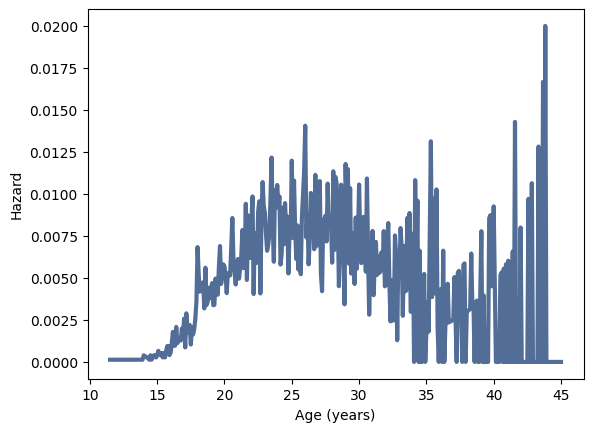

<IPython.core.display.Javascript object>

In [55]:
thinkplot.plot(hf)
thinkplot.config(xlabel="Age (years)", ylabel="Hazard")

## Estimating the survival curve

Once we have the hazard function, we can estimate the survival curve.
The chance of surviving past time `t` is the chance of surviving all
times up through `t`, which is the cumulative product of the
complementary hazard function:

$$[1-\lambda(0)] [1-\lambda(1)] \ldots [1-\lambda(t)]$$

The `HazardFunction` class provides `make_survival`, which computes this
product:

`ts` is the sequence of times where the hazard function is estimated.
`ss` is the cumulative product of the complementary hazard function, so
it is the survival curve.

In [56]:
sf = hf.make_survival()

<IPython.core.display.Javascript object>

The following figure shows the result. The survival curve is
steepest between 25 and 35, when most women get married. Between 35 and
45, the curve is nearly flat, indicating that women who do not marry
before age 35 are unlikely to get married.

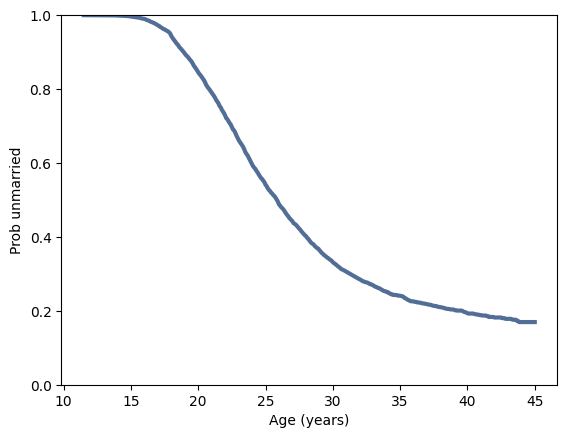

<IPython.core.display.Javascript object>

In [57]:
thinkplot.plot(sf)
thinkplot.config(xlabel="Age (years)", ylabel="Prob unmarried", ylim=[0, 1])

A curve like this was the basis of a famous magazine article in 1986;
*Newsweek* reported that a 40-year old unmarried woman was "more likely
to be killed by a terrorist" than get married. These statistics were
widely reported and became part of popular culture, but they were wrong
then (because they were based on faulty analysis) and turned out to be
even more wrong (because of cultural changes that were already in
progress and continued). In 2006, *Newsweek* ran an another article
admitting that they were wrong.

I encourage you to read more about this article, the statistics it was
based on, and the reaction. It should remind you of the ethical
obligation to perform statistical analysis with care, interpret the
results with appropriate skepticism, and present them to the public
accurately and honestly.

## Confidence intervals

Kaplan-Meier analysis yields a single estimate of the survival curve,
but it is also important to quantify the uncertainty of the estimate. As
usual, there are three possible sources of error: measurement error,
sampling error, and modeling error.

In this example, measurement error is probably small. People generally
know when they were born, whether they've been married, and when. And
they can be expected to report this information accurately.

We can quantify sampling error by resampling. Here's the code:

In [58]:
def estimate_marriage_survival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    hf = estimate_hazard_function(complete, ongoing)
    sf = hf.make_survival()
    return hf, sf

<IPython.core.display.Javascript object>

In [63]:
from thinkstats import resample_rows_weighted
from thinkstats import percentile_rows


def resample_survival(resp, iters=101):
    """Resamples respondents and estimates the survival function.

    resp: DataFrame of respondents
    iters: number of resamples
    """
    _, sf = estimate_marriage_survival(resp)
    thinkplot.plot(sf)
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12.0)
    ss_seq = []
    for _ in range(iters):
        sample = resample_rows_weighted(resp)
        _, sf = estimate_marriage_survival(sample)
        ss_seq.append(sf.probs(ts))
    low, high = percentile_rows(ss_seq, [5, 95])
    thinkplot.fill_between(ts, low, high, color="gray", label="90% CI")

<IPython.core.display.Javascript object>

`resample_survival` takes `resp`, a `DataFrame` of respondents, and
`iters`, the number of times to resample. It computes `ts`, which is the
sequence of ages where we will evaluate the survival curves.

Inside the loop, `resample_survival`:

-   Resamples the respondents using `resample_rows_weighted`, which ...

-   Calls `estimate_marriage_survival`, which uses the process in the previous
    sections to estimate the hazard and survival curves, and

-   Evaluates the survival curve at each age in `ts`.

`ss_seq` is a sequence of evaluated survival curves. `percentile_rows`
takes this sequence and computes the 5th and 95th percentiles, returning
a 90% confidence interval for the survival curve.

The following figure shows the result along with the survival curve we
estimated in the previous section.

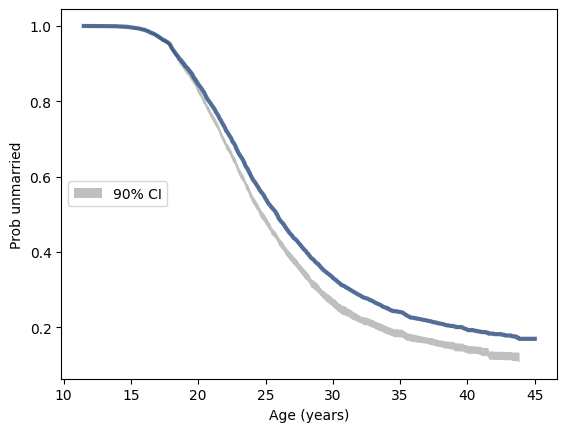

<IPython.core.display.Javascript object>

In [64]:
resample_survival(resp)

thinkplot.config(
    xlabel="Age (years)",
    ylabel="Prob unmarried",
)

The confidence interval takes into
account the sampling weights, unlike the estimated curve. The
discrepancy between them indicates that the sampling weights have a
substantial effect on the estimate -- we will have to keep that in mind.

## Cohort effects

One of the challenges of survival analysis is that different parts of
the estimated curve are based on different groups of respondents. The
part of the curve at time `t` is based on respondents whose age was at
least `t` when they were interviewed. So the leftmost part of the curve
includes data from all respondents, but the rightmost part includes only
the oldest respondents.

If the relevant characteristics of the respondents are not changing over
time, that's fine, but in this case it seems likely that marriage
patterns are different for women born in different generations. We can
investigate this effect by grouping respondents according to their
decade of birth. Groups like this, defined by date of birth or similar
events, are called **cohorts**, and differences between the groups are
called **cohort effects**.

To investigate cohort effects in the NSFG marriage data, I gathered the
Cycle 6 data from 2002 used throughout this book, the Cycle 7 data from
2006--2010, and the Cycle 5 data from 1995.

In [65]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/1995FemRespData.dat.gz")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/2006_2010_FemResp.dat.gz"
)

Downloaded 1995FemRespData.dat.gz
Downloaded 2006_2010_FemRespSetup.dct
Downloaded 2006_2010_FemResp.dat.gz


<IPython.core.display.Javascript object>

In [66]:
resp5 = nsfg.read_fem_resp1995()
resp6 = nsfg.read_fem_resp2002()
resp7 = nsfg.read_fem_resp2010()
resps = [resp5, resp6, resp7]

<IPython.core.display.Javascript object>

For each `DataFrame` we can use `cmbirth` to compute the decade of
birth for each respondent:

In [67]:
for resp in resps:
    month0 = pd.to_datetime("1899-12-15")
    dates = [(month0 + pd.DateOffset(months=cm)) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

<IPython.core.display.Javascript object>

`cmbirth` is encoded as the integer number of months since December
1899; `month0` represents that date as a Timestamp object. For each
birth date, we instantiate a `DateOffset` that contains the
century-month and add it to `month0`; the result is a sequence of
Timestamps, which is converted to a `DateTimeIndex`. Finally, we extract
`year` and compute decades.

Intro...

In [68]:
def add_labels_by_decade(groups, **options):
    """Draws fake points in order to add labels to the legend.

    groups: GroupBy object
    """
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.plot([15], [1], label=label, **options)

<IPython.core.display.Javascript object>

In [69]:
def estimate_marriage_survival_by_decade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    for _, group in groups:
        _, sf = estimate_marriage_survival(group)
        thinkplot.plot(sf, **options)

<IPython.core.display.Javascript object>

To take into account the sampling weights, and also to show variability
due to sampling error, I resample the data, group respondents by decade,
and plot survival curves:

In [70]:
def plot_resampled_by_decade(resps, iters=11, predict_flag=False, omit=None):
    """Plots survival curves for resampled data.

    resps: list of DataFrames
    iters: number of resamples to plot
    predict_flag: whether to also plot predictions
    """
    for i in range(iters):
        samples = [resample_rows_weighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]
        if i == 0:
            add_labels_by_decade(groups, alpha=0.7)
        if predict_flag:
            plot_predictions_by_decade(groups, alpha=0.1)
            estimate_marriage_survival_by_decade(groups, alpha=0.1)
        else:
            estimate_marriage_survival_by_decade(groups, alpha=0.2)

<IPython.core.display.Javascript object>

Data from the three NSFG cycles use different sampling weights, so I
resample them separately and then use `concat` to merge them into a
single DataFrame. The parameter `ignore_index` tells `concat` not to
match up respondents by index; instead it creates a new index from 0 to
30768.

`estimate_marriage_survival_by_decade` plots survival curves for each cohort:

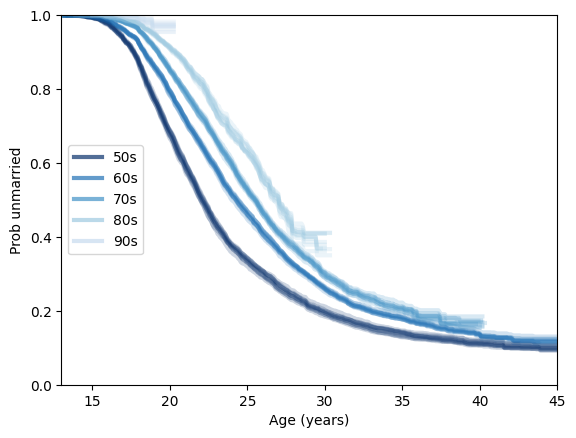

<IPython.core.display.Javascript object>

In [72]:
plot_resampled_by_decade(resps)
thinkplot.config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1]
)

Several patterns are visible:

-   Women born in the 50s married earliest, with successive cohorts
    marrying later and later, at least until age 30 or so.

-   Women born in the 60s follow a surprising pattern. Prior to age 25,
    they were marrying at slower rates than their predecessors. After
    age 25, they were marrying faster. By age 32 they had overtaken the
    50s cohort, and at age 44 they are substantially more likely to have
    married.

Women born in the 60s turned 25 between 1985 and 1995. Remembering
that the *Newsweek* article I mentioned was published in 1986, it is
tempting to imagine that the article triggered a marriage boom. That
explanation would be too pat, but it is possible that the article
and the reaction to it were indicative of a mood that affected the
behavior of this cohort.

-   The pattern of the 70s cohort is similar. They are less likely than
    their predecessors to be married before age 25, but at age 35 they
    have caught up with both of the previous cohorts.

-   Women born in the 80s are even less likely to marry before age 25.
    What happens after that is not clear; for more data, we have to wait
    for the next cycle of the NSFG.

In the meantime we can make some predictions.

## Extrapolation

The survival curve for the 70s cohort ends at about age 38; for the 80s
cohort it ends at age 28, and for the 90s cohort we hardly have any data
at all.

We can extrapolate these curves by "borrowing" data from the previous
cohort. HazardFunction provides a method, `Extend`, that copies the tail
from another longer HazardFunction:

The `HazardFunction` contains a Series that maps from
$t$ to $\lambda(t)$.
`Extend` finds `last`, which is the last index in
`self.series`, selects values from `other` that come later than `last`,
and appends them onto `self.series`.

Now we can extend the `HazardFunction` for each cohort, using values from
the predecessor:

In [73]:
def plot_predictions_by_decade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    hfs = []
    for _, group in groups:
        hf, sf = estimate_marriage_survival(group)
        hfs.append(hf)

    for i, hf in enumerate(hfs):
        if i > 0:
            hf.extend(hfs[i - 1])
        sf = hf.make_survival()
        thinkplot.plot(sf, **options)

<IPython.core.display.Javascript object>

`groups` is a GroupBy object with respondents grouped by decade of
birth. The first loop computes the HazardFunction for each group.

The second loop extends each HazardFunction with values from its
predecessor, which might contain values from the previous group, and so
on. Then it converts each HazardFunction to a SurvivalFunction and plots
it.

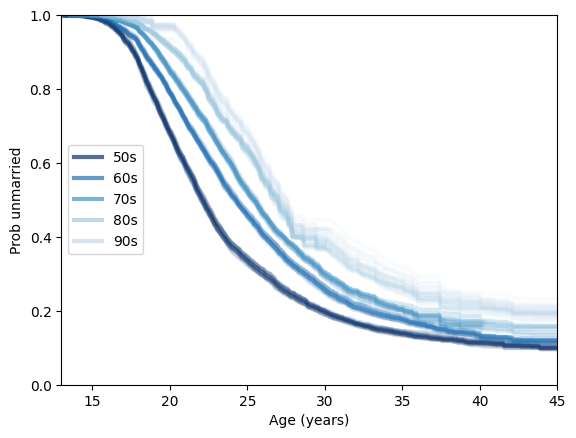

<IPython.core.display.Javascript object>

In [74]:
plot_resampled_by_decade(resps, predict_flag=True)
thinkplot.config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1]
)

I've removed the 50s cohort to make the predictions more visible.
These results suggest that by age 40, the most recent cohorts will converge with the 60s cohort, with fewer than 20% never married.

## Expected remaining lifetime

Given a survival curve, we can compute the expected remaining lifetime
as a function of current age. For example, given the survival curve of
pregnancy length, we can compute the expected time until delivery.

The first step is to extract the PMF of lifetimes. `SurvivalFunction`
provides a method that does that:

Remember that the SurvivalFunction contains the `Cdf` of lifetimes. The
loop copies the values and probabilities from the `Cdf` into a Pmf.

`cutoff` is the highest probability in the Cdf, which is 1 if the `Cdf` is
complete, and otherwise less than 1. If the `Cdf` is incomplete, we plug
in the provided value, `filler`, to cap it off.

The `Cdf` of pregnancy lengths is complete, so we don't have to worry
about this detail yet.

The next step is to compute the expected remaining lifetime, where
"expected" means average. `SurvivalFunction` provides a method that does
that, too:

`RemainingLifetime` takes `filler`, which is passed along to `MakePmf`,
and `func` which is the function used to summarize the distribution of
remaining lifetimes.

`pmf` is the `Pmf` of lifetimes extracted from the SurvivalFunction. `d`
is a dictionary that contains the results, a map from current age, `t`,
to expected remaining lifetime.

The loop iterates through the values in the Pmf. For each value of `t`
it computes the conditional distribution of lifetimes, given that the
lifetime exceeds `t`. It does that by removing values from the `Pmf` one
at a time and renormalizing the remaining values.

Then it uses `func` to summarize the conditional distribution. In this
example the result is the mean pregnancy length, given that the length
exceeds `t`. By subtracting `t` we get the mean remaining pregnancy
length.

In [75]:
preg = nsfg.read_fem_preg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
print("Number of complete pregnancies", len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print("Number of ongoing pregnancies", len(ongoing))
hf = estimate_hazard_function(complete, ongoing)
sf1 = hf.make_survival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


<IPython.core.display.Javascript object>

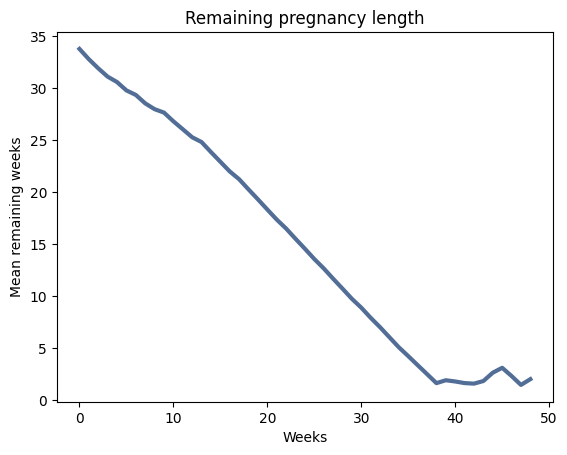

<IPython.core.display.Javascript object>

In [76]:
rem_life1 = sf1.remaining_lifetime()
thinkplot.plot(rem_life1)
thinkplot.config(
    title="Remaining pregnancy length", xlabel="Weeks", ylabel="Mean remaining weeks"
)

Figure [\[survival6\]](#survival6){reference-type="ref"
reference="survival6"} (left) shows the expected remaining pregnancy
length as a function of the current duration. For example, during Week
0, the expected remaining duration is about 34 weeks. That's less than
full term (39 weeks) because terminations of pregnancy in the first
trimester bring the average down.

The curve drops slowly during the first trimester. After 13 weeks, the
expected remaining lifetime has dropped by only 9 weeks, to 25. After
that the curve drops faster, by about a week per week.

Between Week 37 and 42, the curve levels off between 1 and 2 weeks. At
any time during this period, the expected remaining lifetime is the
same; with each week that passes, the destination gets no closer.
Processes with this property are called **memoryless** because the past
has no effect on the predictions. This behavior is the mathematical
basis of the infuriating mantra of obstetrics nurses: "any day now."

Figure [\[survival6\]](#survival6){reference-type="ref"
reference="survival6"} (right) shows the median remaining time until
first marriage, as a function of age. For an 11 year-old girl, the
median time until first marriage is about 14 years. The curve decreases
until age 22 when the median remaining time is about 7 years. After that
it increases again: by age 30 it is back where it started, at 14 years.

In [77]:
hf, sf2 = estimate_marriage_survival(resp6)

<IPython.core.display.Javascript object>

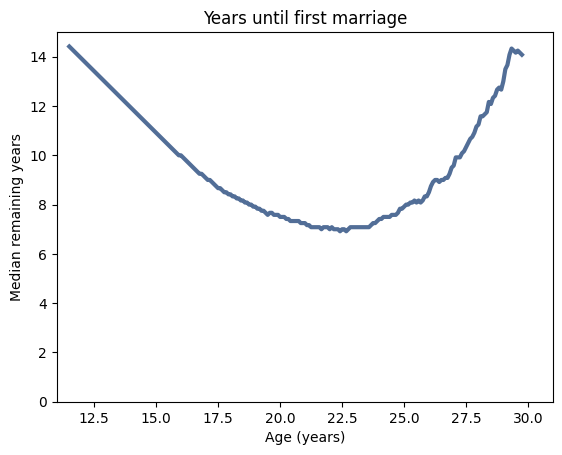

<IPython.core.display.Javascript object>

In [78]:
func = lambda pmf: pmf.percentile(50)
rem_life2 = sf2.remaining_lifetime(filler=np.inf, func=func)
thinkplot.plot(rem_life2)
thinkplot.config(
    title="Years until first marriage",
    ylim=[0, 15],
    xlim=[11, 31],
    xlabel="Age (years)",
    ylabel="Median remaining years",
)

Based on this data, young women have decreasing remaining "lifetimes".
Mechanical components with this property are called **NBUE** for "new
better than used in expectation," meaning that a new part is expected to
last longer.

Women older than 22 have increasing remaining time until first marriage.
Components with this property are called **UBNE** for "used better than
new in expectation." That is, the older the part, the longer it is
expected to last. Newborns and cancer patients are also UBNE; their life
expectancy increases the longer they live.

For this example I computed median, rather than mean, because the `Cdf` is
incomplete; the survival curve projects that about 20% of respondents
will not marry before age 44. The age of first marriage for these women
is unknown, and might be non-existent, so we can't compute a mean.

I deal with these unknown values by replacing them with `np.inf`, a
special value that represents infinity. That makes the mean infinity for
all ages, but the median is well-defined as long as more than 50% of the
remaining lifetimes are finite, which is true until age 30. After that
it is hard to define a meaningful expected remaining lifetime.



## Glossary

-   **survival analysis**: A set of methods for describing and
    predicting lifetimes, or more generally time until an event occurs.

-   **survival curve**: A function that maps from a time, $t$, to the
    probability of surviving past $t$.

-   **hazard function**: A function that maps from $t$ to the fraction
    of people alive until $t$ who die at $t$.

-   **Kaplan-Meier estimation**: An algorithm for estimating hazard and
    survival functions.

-   **cohort**: a group of subjects defined by an event, like date of
    birth, in a particular interval of time.

-   **cohort effect**: a difference between cohorts.

-   **NBUE**: A property of expected remaining lifetime, "New better
    than used in expectation."

-   **UBNE**: A property of expected remaining lifetime, "Used better
    than new in expectation."

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [79]:
def clean_data(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp["cmdivorcx"] = resp.cmdivorcx.replace([9998, 9999], np.nan)
    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0
    month0 = pd.to_datetime("1899-12-15")
    dates = [(month0 + pd.DateOffset(months=cm)) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

<IPython.core.display.Javascript object>

In [80]:
clean_data(resp6)
married6 = resp6[resp6.evrmarry == 1]
clean_data(resp7)
married7 = resp7[resp7.evrmarry == 1]

<IPython.core.display.Javascript object>

In [82]:
# Solution

def resample_divorce_curve_by_decade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [resample_rows_weighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            add_labels_by_decade(groups, alpha=0.7)
        estimate_survival_by_decade(groups, alpha=0.1)
    thinkplot.config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

<IPython.core.display.Javascript object>

In [83]:
# Solution

def estimate_survival_by_decade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    for name, group in groups:
        _, sf = estimate_survival(group)
        thinkplot.plot(sf, **options)

<IPython.core.display.Javascript object>

In [84]:
# Solution

def estimate_survival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()
    hf = estimate_hazard_function(complete, ongoing)
    sf = hf.make_survival()
    return hf, sf

<IPython.core.display.Javascript object>

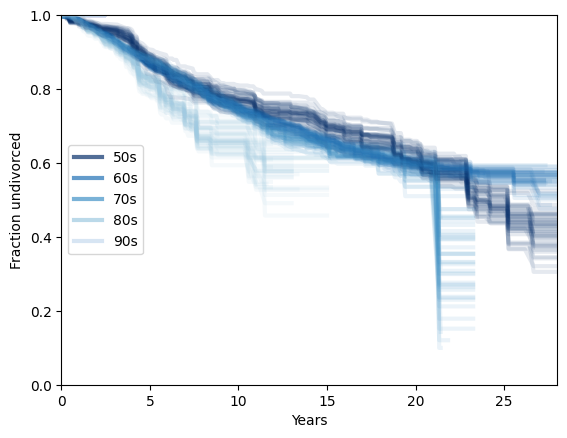

<IPython.core.display.Javascript object>

In [85]:
# Solution

resample_divorce_curve_by_decade([married6, married7])